<a href="https://colab.research.google.com/github/NancyBiyahut/intrusion-detection-autoencoder/blob/main/LSTMautoencoder_reduced_no_of_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from mpl_toolkits import mplot3d
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from scipy.spatial.distance import euclidean
from tensorflow.keras.regularizers import L1
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score, precision_score, recall_score, accuracy_score

In [5]:
df= pd.read_csv('kdd_train1.csv')
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [6]:
df= pd.read_csv('kdd_train1.csv')
data=df.copy()
categorical_features=[feature for feature in  df.columns if data[feature].dtypes=='O']
categorical_features

['protocol_type', 'service', 'flag', 'labels']

In [7]:
df_http = df[(df['service']=='http')]

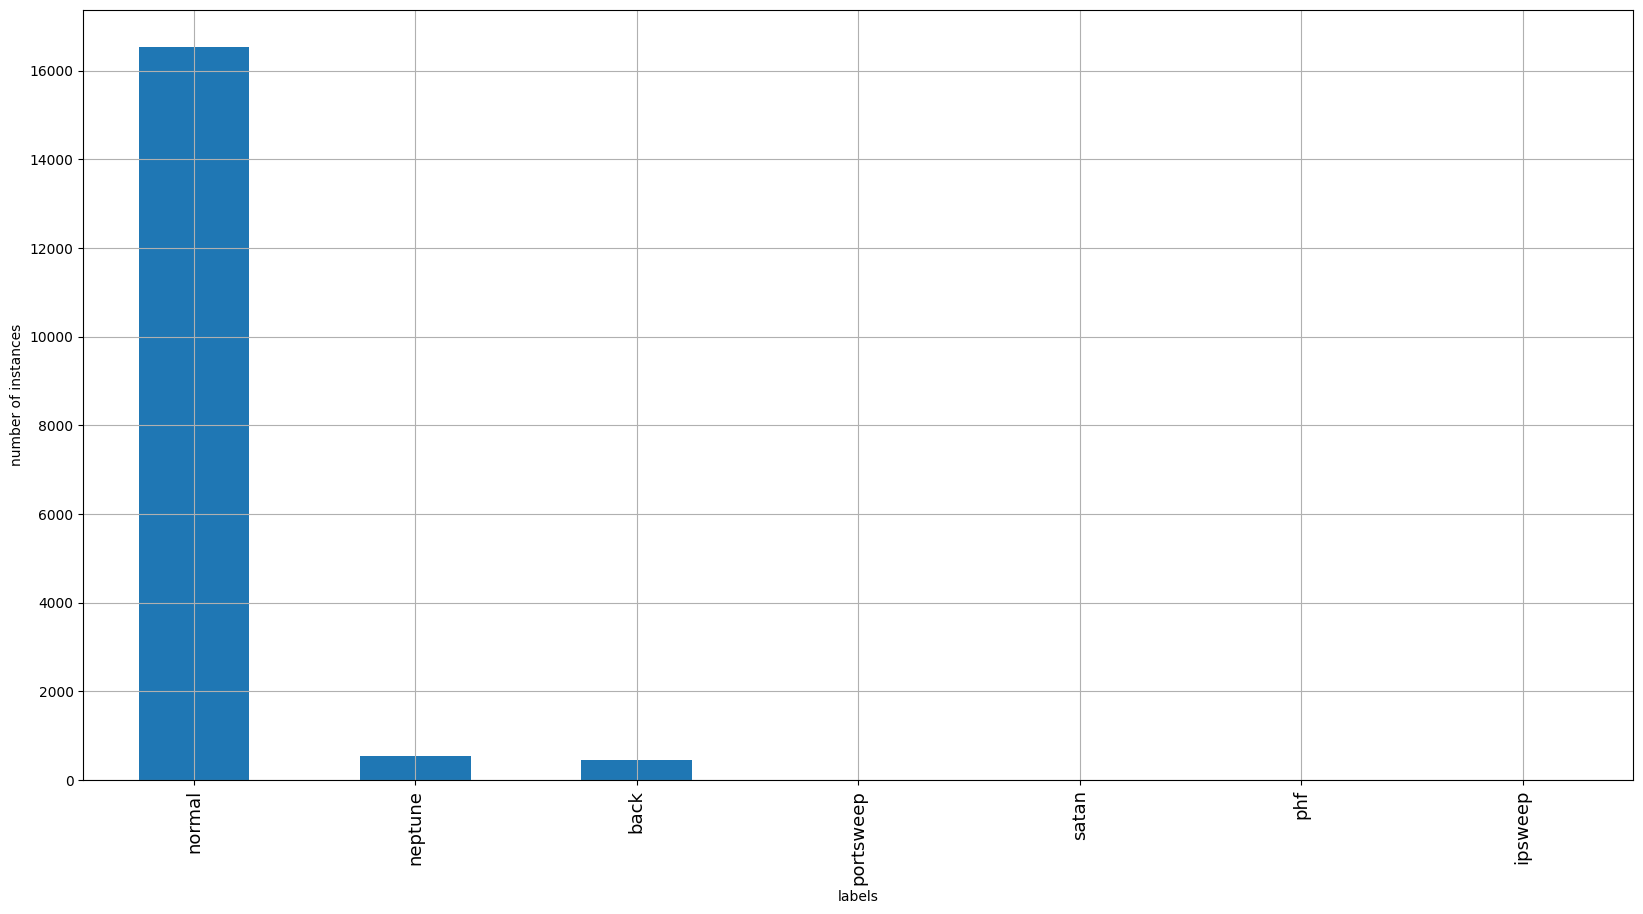

In [8]:
pd.value_counts(df_http['labels']).plot(kind='bar', figsize=(20, 10))
plt.ylabel('number of instances')
plt.xticks(fontsize=13)
plt.grid()
plt.show()

In [9]:
print('different types of services: {}'.format(df['service'].unique()))

different types of services: ['ftp_data' 'other' 'private' 'http' 'remote_job' 'name' 'netbios_ns'
 'eco_i' 'mtp' 'telnet' 'finger' 'domain_u' 'supdup' 'uucp_path' 'Z39_50'
 'smtp' 'csnet_ns' 'uucp' 'netbios_dgm' 'urp_i' 'auth' 'domain' 'ftp'
 'bgp' 'ldap' 'ecr_i' 'gopher' 'vmnet' 'systat' 'http_443' 'efs' 'whois'
 'imap4' 'iso_tsap' 'echo' 'klogin' 'link' 'sunrpc' 'login' 'kshell'
 'sql_net' 'time' 'hostnames' 'exec' 'ntp_u' 'discard' 'nntp' 'courier'
 'ctf' 'ssh' 'daytime' 'shell' 'netstat' 'pop_3' 'nnsp' 'IRC' 'pop_2'
 'printer' 'tim_i' 'pm_dump' 'red_i' 'netbios_ssn' 'rje' 'X11' 'urh_i'
 'http_8001' 'aol' 'http_2784']


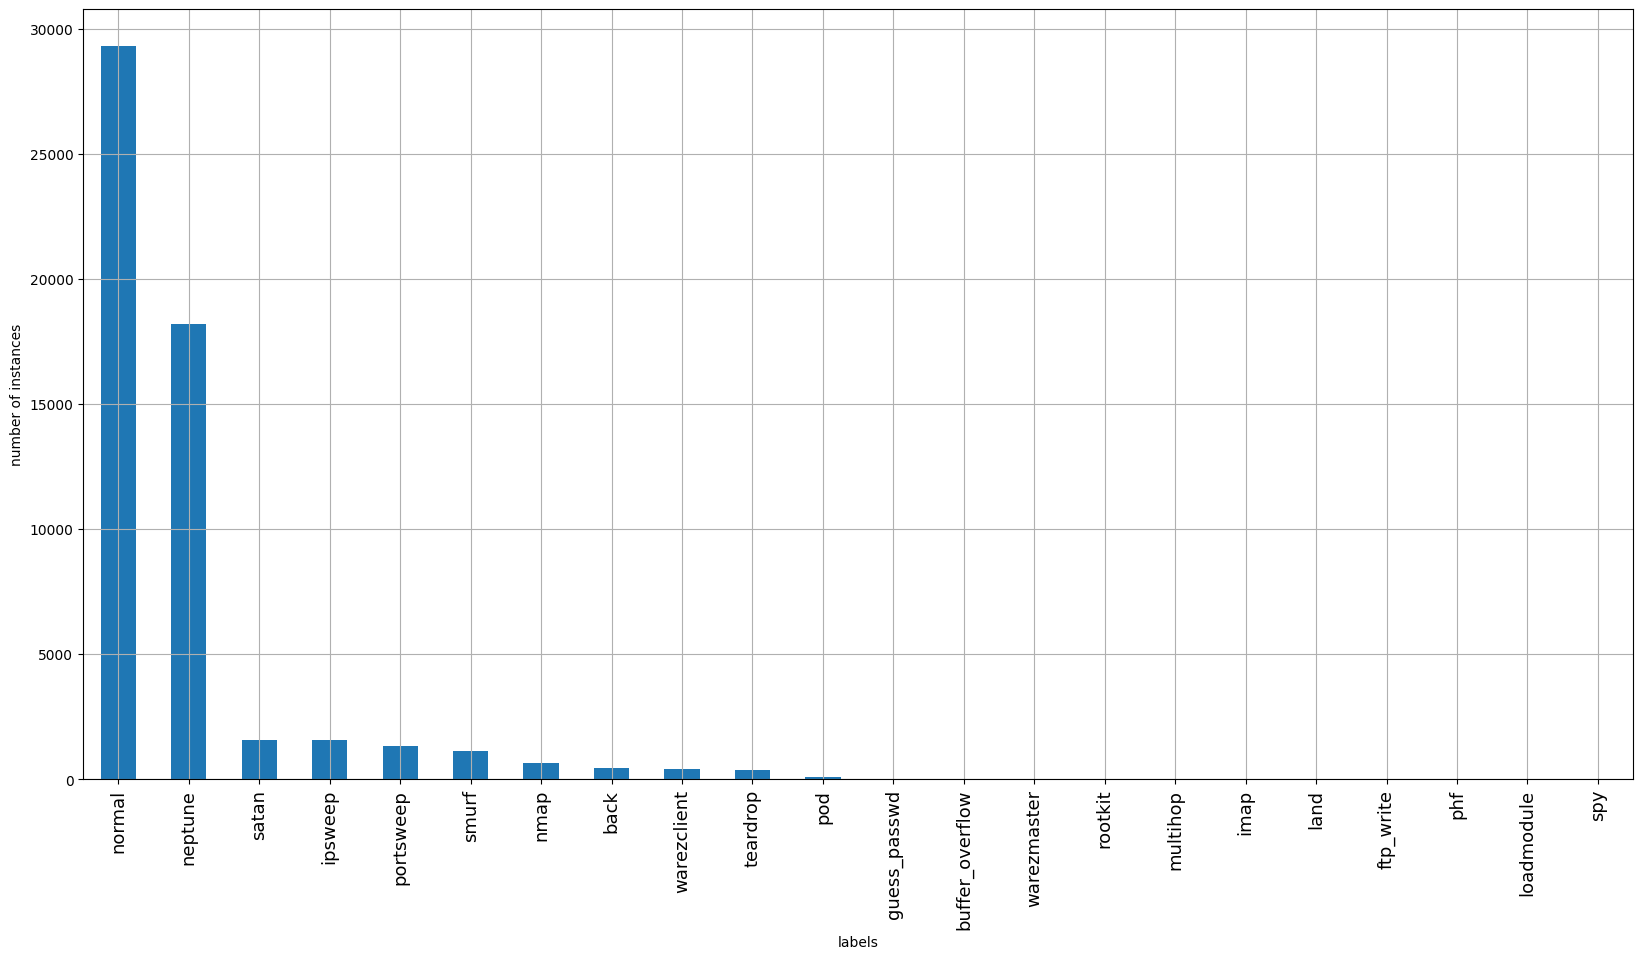

In [10]:
pd.value_counts(df['labels']).plot(kind='bar', figsize=(20, 10))
plt.ylabel('number of instances')
plt.xticks(fontsize=13)
plt.grid()
plt.show()

In [11]:
# extracting only the rows which have http service.
df_http = df[(df['service']=='http')]

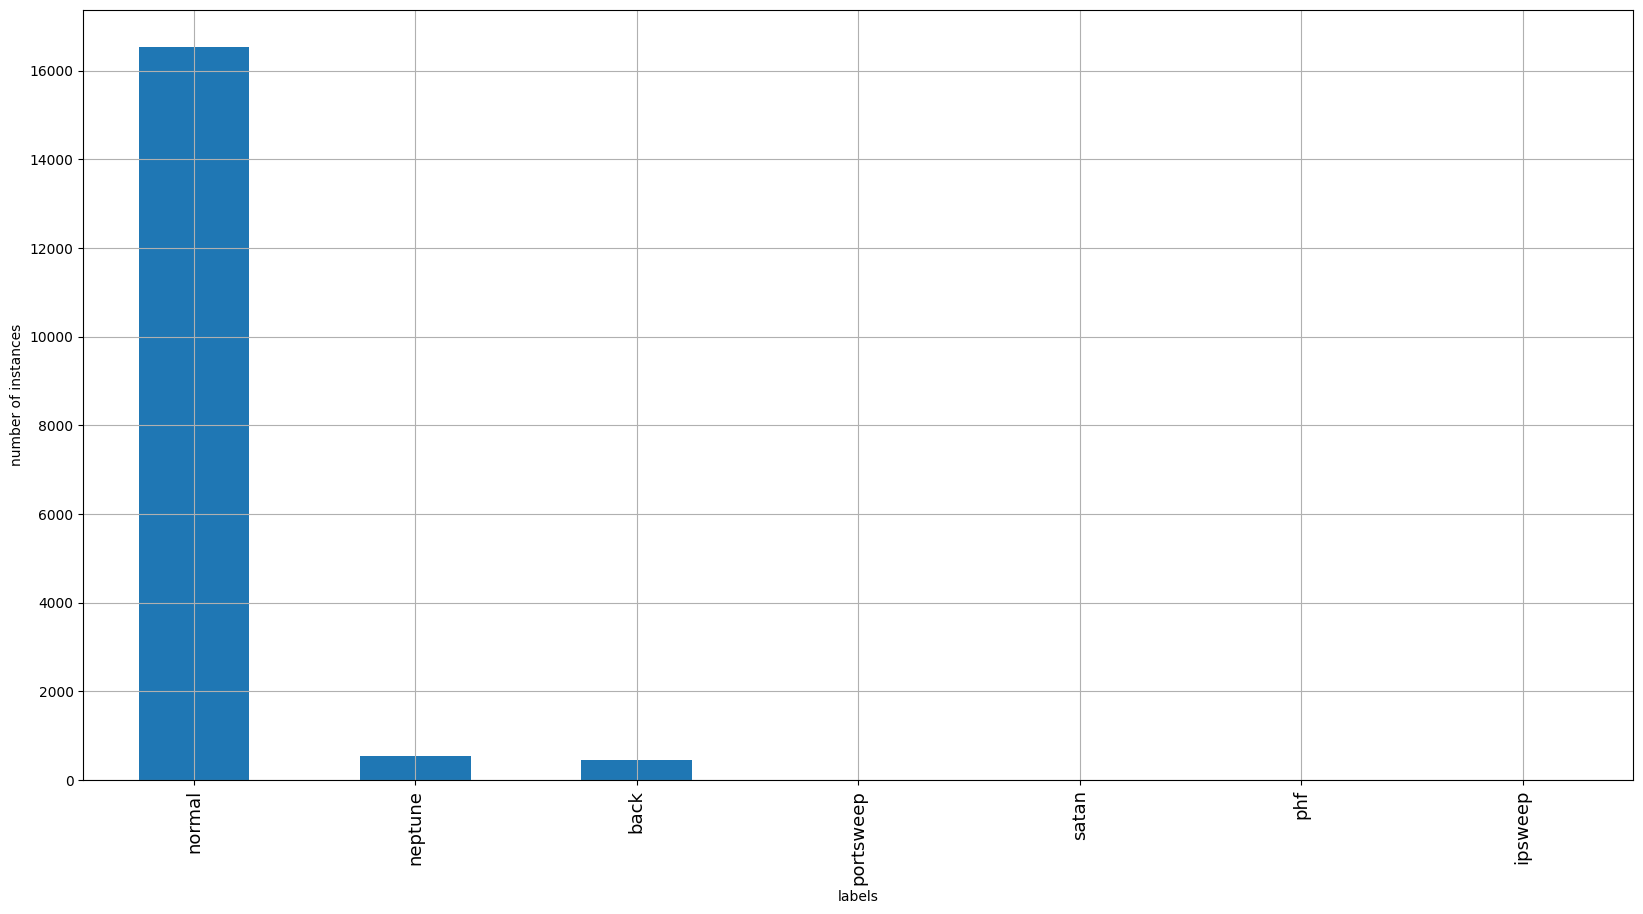

In [12]:
pd.value_counts(df_http['labels']).plot(kind='bar', figsize=(20, 10))
plt.ylabel('number of instances')
plt.xticks(fontsize=13)
plt.grid()
plt.show()

In [13]:
normal_instances = df_http[df_http['labels']=='normal'].shape[0]
anomalous_instances = df_http[df_http['labels']!='normal'].shape[0]
print(normal_instances)
print(anomalous_instances)
print('percentage of anomalies = {}'.format(100*anomalous_instances/normal_instances))

16546
995
percentage of anomalies = 6.013538015230267


In [14]:
df_http_normal = df_http[df_http['labels']=='normal']

In [15]:
df_http_normal.shape

(16546, 42)

In [16]:
# dropping catrgorical columns
df_http_normal.drop(['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', 'labels'], axis=1, inplace=True)
# dropping columns with no std deviation
df_http_normal.drop(['wrong_fragment', 'urgent', 'num_failed_logins', 'su_attempted', 'num_file_creations', 'num_outbound_cmds'], axis=1, inplace=True)

<ipython-input-16-c7b3529d7086>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_http_normal.drop(['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', 'labels'], axis=1, inplace=True)
<ipython-input-16-c7b3529d7086>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_http_normal.drop(['wrong_fragment', 'urgent', 'num_failed_logins', 'su_attempted', 'num_file_creations', 'num_outbound_cmds'], axis=1, inplace=True)


In [17]:
df_http_normal.describe()

,duration,src_bytes,dst_bytes,hot,num_compromised,root_shell,num_root,num_shells,num_access_files,count,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,16546.000000,16546.000000,1.654600e+04,16546.000000,16546.000000,16546.000000,16546.0,16546.0,16546.000000,16546.000000,...,16546.000000,16546.000000,16546.000000,16546.000000,16546.000000,16546.000000,16546.000000,16546.000000,16546.000000,16546.000000
mean,0.796628,242.453161,4.568196e+03,0.012027,0.001692,0.001451,0.0,0.0,0.005258,9.128490,...,126.118397,243.195516,0.996326,0.000994,0.068641,0.030175,0.005064,0.001189,0.068363,0.069393
std,14.763224,108.442483,2.191626e+04,0.165762,0.073735,0.038059,0.0,0.0,0.072324,13.205837,...,104.446635,42.867942,0.032468,0.010799,0.171616,0.047297,0.046529,0.007723,0.240002,0.237924
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,211.000000,4.800000e+02,0.000000,0.000000,0.000000,0.0,0.0,0.000000,2.000000,...,23.000000,255.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,242.000000,1.469000e+03,0.000000,0.000000,0.000000,0.0,0.0,0.000000,6.000000,...,94.000000,255.000000,1.000000,0.000000,0.010000,0.020000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,303.000000,3.938000e+03,0.000000,0.000000,0.000000,0.0,0.0,0.000000,13.000000,...,255.000000,255.000000,1.000000,0.000000,0.040000,0.040000,0.000000,0.000000,0.000000,0.000000
max,715.000000,3836.000000,1.524348e+06,9.000000,4.000000,1.000000,0.0,0.0,1.000000,511.000000,...,255.000000,255.000000,1.000000,0.670000,1.000000,1.000000,1.000000,0.400000,1.000000,1.000000


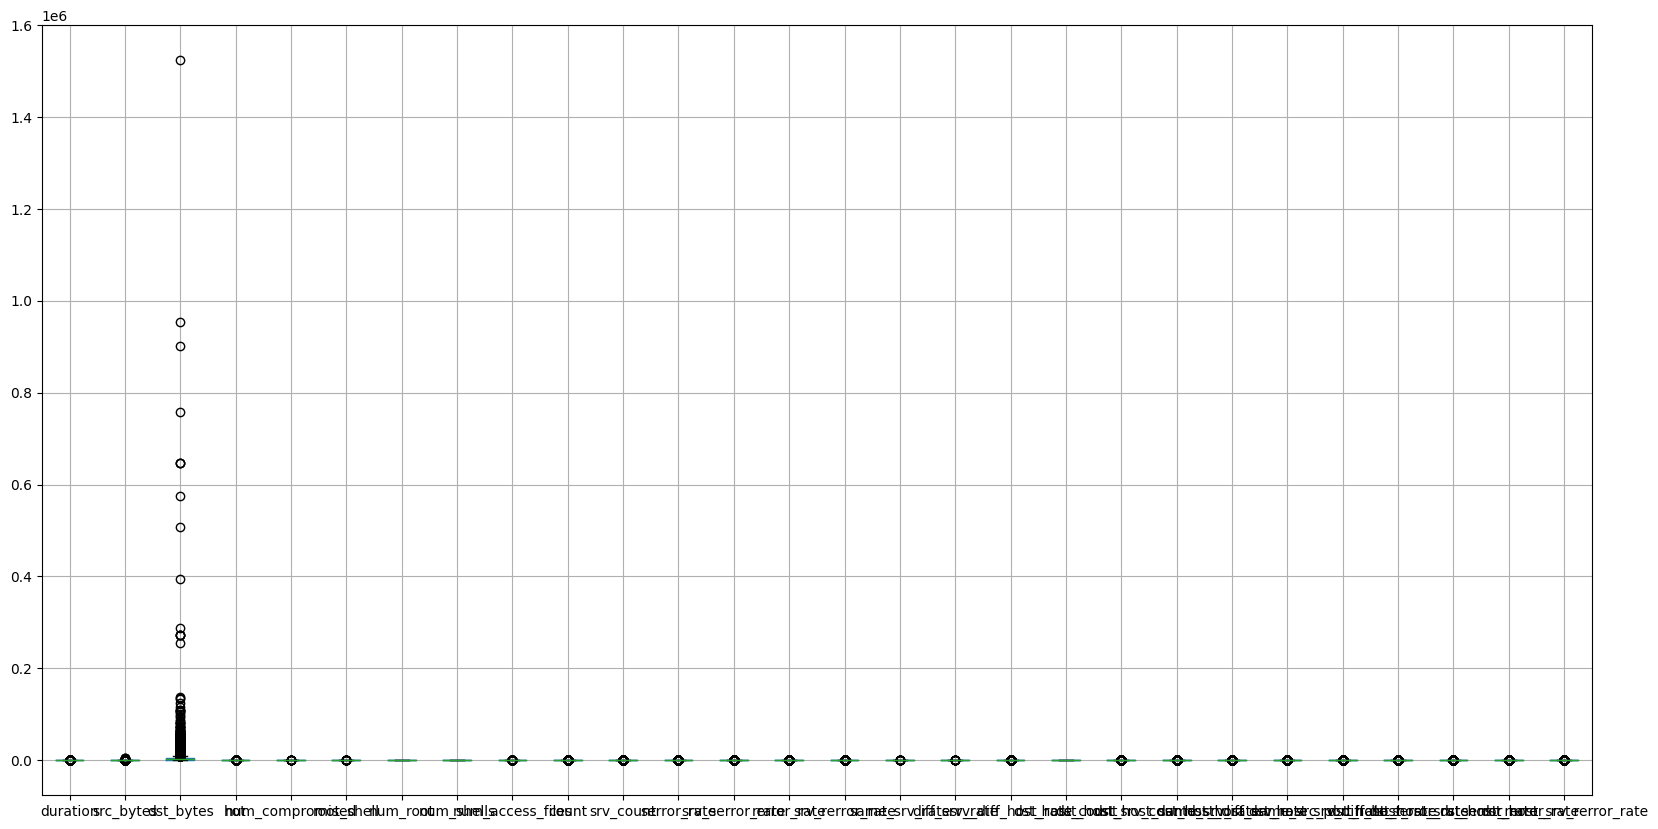

In [18]:
df_http_normal.boxplot(figsize=(20, 10))
plt.show()

In [66]:
# scaling the data using standard scaler
scaler = StandardScaler()
df_http_normal = pd.DataFrame(scaler.fit_transform(df_http_normal), columns=df_http_normal.columns)

In [70]:
# reducing the dimensionality of the data using PCA and covering 80% of the variance in the original data
pca = PCA(n_components=0.8)
pca.fit(df_http_normal)

PCA(n_components=0.8)

In [71]:
pca_cols = ['PCA_'+ str(i) for i in range(pca.n_components_)]
df_pca = pd.DataFrame(pca.transform(df_http_normal), columns=pca_cols)

In [72]:
df_pca.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11
0,-0.029080,2.915457,0.206631,0.476548,-0.489243,-0.028304,-0.073721,0.224261,0.254932,-0.545981,0.339828,-0.434322
1,-1.366964,-1.005056,0.706935,1.319658,-0.078618,-0.937774,-0.875194,-0.056483,0.081003,0.351793,-0.157120,0.370545
2,0.029682,0.324674,-0.644570,-0.787916,-0.130924,1.018836,0.419335,-0.265466,-0.191514,0.165820,-0.611976,1.024291
3,-0.633857,0.619688,-0.179336,-0.065737,0.063291,-0.039342,0.425864,0.197321,-0.112961,-0.077697,-0.161142,0.355859
4,-0.296685,0.043556,-0.494592,-0.432632,-0.112358,0.315487,0.397561,-0.041393,-0.275024,-0.257729,0.308372,-0.590848


In [73]:
def get_windows(df, window_size=20, stride=10):
  windows_arr = []
  for i in tqdm.tqdm(range(0, len(df)-window_size+1, stride)):
    windows_arr.append(df.iloc[i:i+window_size, :].to_numpy())
  return np.array(windows_arr)

In [74]:
window_size, stride = 10, 10
windows_arr = get_windows(df_pca, window_size, stride)

100%|██████████| 1654/1654 [00:00<00:00, 14358.64it/s]


In [75]:
# shuffling windows for training purpose
indices = np.arange(windows_arr.shape[0])
np.random.shuffle(indices)
windows_shuffled = windows_arr[indices]

LSTM Autoencoder

In [33]:

K.clear_session()
# encoder model with stacked LSTM
encoder = Sequential([LSTM(80, return_sequences=True, activation='selu',input_shape=(window_size, 12), dropout=0.2), LSTM(50, activation='selu', return_sequences=True),
                      LSTM(20, activation='selu')], name='encoder')
# decoder model with output dimension same as input dimension
decoder = Sequential([RepeatVector(window_size), LSTM(50, activation='selu', return_sequences=True), LSTM(80, activation='selu',return_sequences=True),
                      TimeDistributed(Dense(12, activation='linear'))], name='decoder')
# creating sequential autoencoder using encoder, decoder as layers
autoencoder = Sequential([encoder, decoder], name='autoencoder')
autoencoder.compile(optimizer = 'sgd', loss='cosine_similarity')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 20)                61640     
                                                                 
 decoder (Sequential)        (None, 10, 12)            57092     
                                                                 
Total params: 118732 (463.80 KB)
Trainable params: 118732 (463.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [76]:
K.clear_session()
encoder = Sequential([
    LSTM(80, return_sequences=True, activation='selu', input_shape=(window_size,12), dropout=0.2),
    LSTM(20, activation='selu')  # Reduced to 1 layer
], name='encoder')

# decoder model with output dimension same as input dimension
decoder = Sequential([
    RepeatVector(window_size),
    LSTM(20, activation='selu', return_sequences=True),  # Reduced to 1 layer
    TimeDistributed(Dense(12, activation='linear'))
], name='decoder')

# creating sequential autoencoder using encoder, decoder as layers
autoencoder = Sequential([encoder, decoder], name='autoencoder')
autoencoder.compile(optimizer='sgd', loss='cosine_similarity')  # Using SGD optimizer, cosine similarity loss
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 20)                37840     
                                                                 
 decoder (Sequential)        (None, 10, 12)            3532      
                                                                 
Total params: 41372 (161.61 KB)
Trainable params: 41372 (161.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [78]:
encoder.summary(), decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 80)            29760     
                                                                 
 lstm_1 (LSTM)               (None, 20)                8080      
                                                                 
Total params: 37840 (147.81 KB)
Trainable params: 37840 (147.81 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 repeat_vector (RepeatVecto  (None, 10, 20)            0         
 r)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 10, 20)            3280      
    

(None, None)

In [79]:
check_point = tf.keras.callbacks.ModelCheckpoint('autoencoder.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
train_hist = autoencoder.fit(windows_shuffled, windows_shuffled[:, :, ::-1], batch_size=64, validation_split=0.2, epochs=100, callbacks=[check_point])

Epoch 1/100
20/21 [===========================>..] - ETA: 0s - loss: -0.1158
Epoch 1: val_loss improved from inf to -0.21744, saving model to autoencoder.h5
21/21 [==============================] - 5s 57ms/step - loss: -0.1194 - val_loss: -0.2174
Epoch 2/100
 7/21 [=========>....................] - ETA: 0s - loss: -0.2181

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/21 [==========================>...] - ETA: 0s - loss: -0.2387
Epoch 2: val_loss improved from -0.21744 to -0.26466, saving model to autoencoder.h5
21/21 [==============================] - 1s 29ms/step - loss: -0.2394 - val_loss: -0.2647
Epoch 3/100
19/21 [==========================>...] - ETA: 0s - loss: -0.2705
Epoch 3: val_loss improved from -0.26466 to -0.28665, saving model to autoencoder.h5
21/21 [==============================] - 1s 27ms/step - loss: -0.2712 - val_loss: -0.2867
Epoch 4/100
20/21 [===========================>..] - ETA: 0s - loss: -0.2878
Epoch 4: val_loss improved from -0.28665 to -0.29971, saving model to autoencoder.h5
21/21 [==============================] - 1s 28ms/step - loss: -0.2877 - val_loss: -0.2997
Epoch 5/100
20/21 [===========================>..] - ETA: 0s - loss: -0.2987
Epoch 5: val_loss improved from -0.29971 to -0.30846, saving model to autoencoder.h5
21/21 [==============================] - 1s 38ms/step - loss: -0.2991 - val_loss: -0.3085
Epoc

In [80]:
# restoring the best model
autoencoder_loaded = tf.keras.models.load_model('autoencoder.h5')

Testing

In [81]:
# loading the test dataframe
test_df = pd.read_csv('kdd_test1.csv')
test_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,5,tcp,smtp,SF,2429,475,0,0,0,0,...,57,0.11,0.02,0.01,0.04,0.0,0.0,0.87,0.0,normal
1,0,udp,domain_u,SF,45,134,0,0,0,0,...,155,0.80,0.02,0.01,0.00,0.0,0.0,0.00,0.0,normal
2,0,udp,domain_u,SF,45,80,0,0,0,0,...,255,1.00,0.00,0.01,0.00,0.0,0.0,0.00,0.0,normal
3,1979,udp,other,SF,145,105,0,0,0,0,...,2,0.01,0.84,1.00,0.00,0.0,0.0,0.00,0.0,normal
4,14462,tcp,other,RSTR,1,0,0,0,0,0,...,2,0.01,0.68,1.00,0.00,0.0,0.0,1.00,1.0,portsweep


In [82]:
# slicing only the rows belonging to http service
test_df_http = test_df[test_df['service']=='http']

In [83]:
# binary indicator to represent anomalies
status = pd.Series([0 if i=='normal' else 1 for i in test_df_http['labels']])
test_labels = [1 if np.sum(status[i:i+window_size])>0 else 0 for i in range(0, len(status)-window_size+1, stride)]

In [84]:
# dropping catrgorical columns
test_df_http.drop(['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', 'labels'], axis=1, inplace=True)
# dropping columns with no std deviation
test_df_http.drop(['wrong_fragment', 'urgent', 'num_failed_logins', 'su_attempted', 'num_file_creations', 'num_outbound_cmds'], axis=1, inplace=True)

<ipython-input-84-e48dd4a85e10>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_http.drop(['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', 'labels'], axis=1, inplace=True)
<ipython-input-84-e48dd4a85e10>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_http.drop(['wrong_fragment', 'urgent', 'num_failed_logins', 'su_attempted', 'num_file_creations', 'num_outbound_cmds'], axis=1, inplace=True)


In [85]:
test_df_http = pd.DataFrame(scaler.transform(test_df_http), columns=test_df_http.columns)

In [86]:
test_df_http_pca = pd.DataFrame(pca.transform(test_df_http), columns=pca_cols)
test_df_http_pca.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11
0,-257.648070,491.313218,-68.154009,-214.491713,2168.167980,394.726250,62.453820,2780.836120,-109.170589,138.348509,-119.834092,26.721969
1,-58.243863,-35.386095,38.446598,32.293096,12.156137,-126.432489,32.472942,9.749243,48.178627,-45.672862,10.284226,13.203286
2,-197.324885,15.169156,-14.209519,8.424219,283.347487,-81.387428,83.104137,345.767885,13.259196,4.354987,-10.542219,22.008430
3,-171.762689,59.876759,-55.527776,-17.039136,343.686630,48.682241,51.248873,427.230577,-40.588476,65.182190,-27.903374,14.812081
4,-174.927442,331.944983,-49.395066,-142.109756,1466.530575,262.207674,47.336292,1879.490139,-77.945941,96.621390,-81.347803,17.521777


In [87]:
test_windows = get_windows(test_df_http_pca, window_size=10, stride=10)

100%|██████████| 730/730 [00:00<00:00, 12042.26it/s]


In [88]:
test_windows_pred = autoencoder_loaded.predict(test_windows)

23/23 [==============================] - 1s 8ms/step


In [89]:
# calculating reconstruction error for each sample
# implemented in tensorflow for faster execution when gpu is available

def get_recon_erros(true_windows, pred_windows):
  recon_errors = []

  def cond(y_true, y_pred, i, iters):
    return tf.less(i, iters)

  def body(y_true, y_pred, i, iters):
    tensor_for_error = tf.math.subtract(tf.slice(y_true, [i, 0, 0], [1, -1, -1]), tf.slice(y_pred, [i, 0, 0], [1, -1, -1]))
    tensor_for_error = tf.reshape(tensor_for_error, [window_size, pca.n_components_])
    recon_error = tf.math.reduce_mean(tf.norm(tensor_for_error, ord='euclidean', axis=1))
    # this is the list initialized above
    recon_errors.append(recon_error.numpy())
    return [y_true, y_pred, tf.add(i, 1), iters]

  iters = tf.constant(len(true_windows))

  result = tf.while_loop(cond, body, [tf.constant(true_windows.astype(np.float32)), tf.constant(pred_windows.astype(np.float32)), 0, iters])
  return recon_errors

In [90]:
recon_errors = get_recon_erros(test_windows, test_windows_pred)
recon_errors = np.array(recon_errors).reshape(-1, 1)

In [91]:
# scaling the reconstruction errors set to [0, 1] scale
mm_scaler = MinMaxScaler()
anomaly_scores = mm_scaler.fit_transform(recon_errors).flatten()

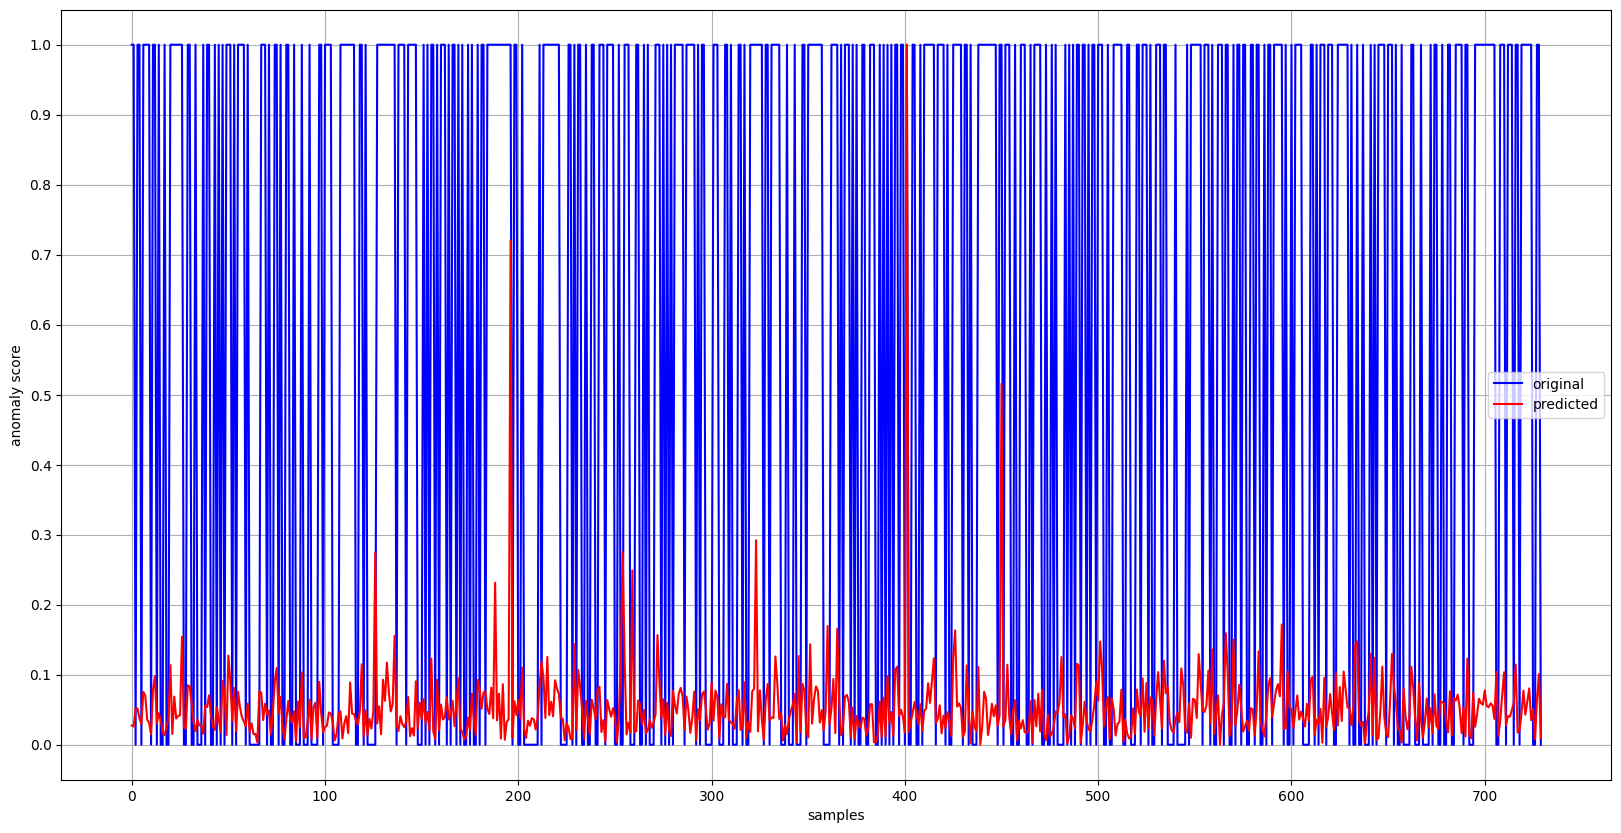

In [92]:
plt.figure(figsize=(20, 10))
plt.plot(test_labels, c='blue', label='original')
plt.plot(anomaly_scores, c='red', label='predicted')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('samples')
plt.ylabel('anomaly score')
plt.grid()
plt.legend()
plt.show()

Measuring the effectiveness of classifier

In [93]:
fpr, tpr, thresholds = roc_curve(test_labels, anomaly_scores)

In [94]:
auc = roc_auc_score(test_labels, anomaly_scores)
print('Area under ROC curve: {}'.format(auc))

Area under ROC curve: 0.7332507539853511


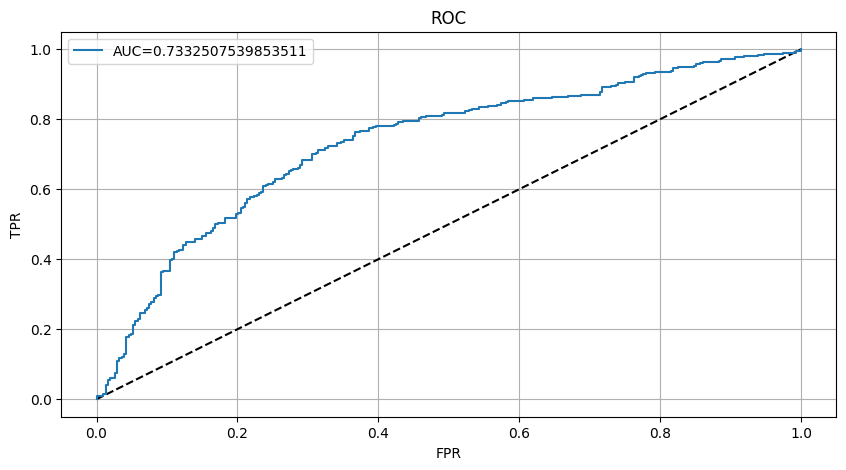

In [95]:
plt.figure(figsize=(10,5))
plt.plot([0, 1], [0, 1], color = 'black', linestyle='--')
plt.plot(fpr, tpr, label='AUC={}'.format(auc))
plt.grid()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC')
plt.show()


Identifying anomalies in test set

In [96]:
anomaly_combinations = [(anomaly_scores>i).astype(np.int32) for i in thresholds]
f1_scores = [f1_score(test_labels, i) for i in anomaly_combinations]

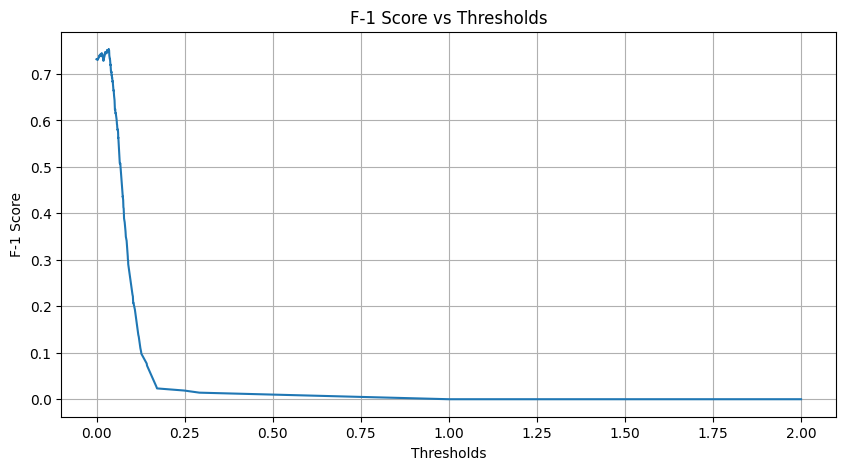

In [97]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds, f1_scores)
plt.grid()
plt.xlabel('Thresholds')
plt.ylabel('F-1 Score')
plt.title('F-1 Score vs Thresholds')
plt.show()

In [98]:
max_f1_score = np.max(f1_scores)
best_threshold = thresholds[f1_scores.index(max_f1_score)]
print('best threshold = {}'.format(best_threshold))

best threshold = 0.03474481776356697


In [99]:
anomaly_indicator = (anomaly_scores>best_threshold).astype(np.int32)

In [100]:
confusion_matrix(test_labels, anomaly_indicator)

array([[187, 121],
       [ 94, 328]])

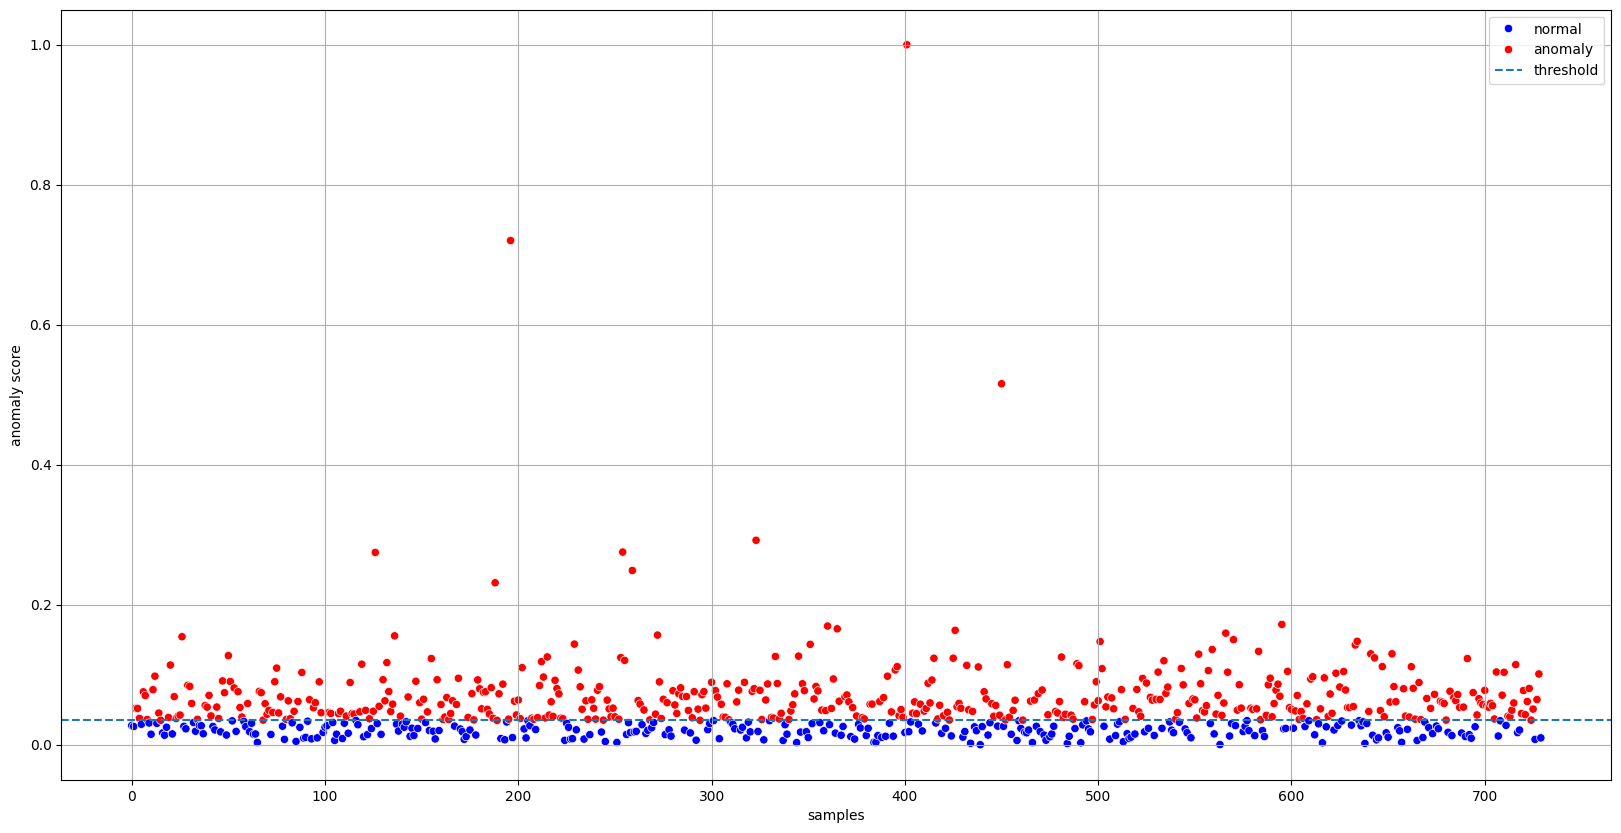

In [101]:
plt.figure(figsize=(20,10))
sns.scatterplot(x=np.arange(0, len(anomaly_scores)), y= anomaly_scores, hue=['normal' if i==0 else 'anomaly' for i in anomaly_indicator],
                palette=['blue', 'red'], legend='full')
plt.axhline(y = best_threshold, linestyle='--', label='threshold')
plt.xlabel('samples')
plt.ylabel('anomaly score')
plt.legend()
plt.grid()
plt.show()

In [102]:
precision = precision_score(test_labels, anomaly_indicator)
recall = recall_score(test_labels, anomaly_indicator)
f1_sc = f1_score(test_labels, anomaly_indicator)
accuracy_sc = accuracy_score(test_labels, anomaly_indicator)

In [103]:
print('Model has the following classification metrics:\n precision = {}\n recall = {}\n f1_score = {}\n accuracy_score = {}'
      .format(precision, recall, f1_sc, accuracy_sc))

Model has the following classification metrics:
 precision = 0.7305122494432071
 recall = 0.7772511848341233
 f1_score = 0.7531572904707234
 accuracy_score = 0.7054794520547946
